In [1]:
import os
from sklearn.mixture import GaussianMixture
from exp.nb_nb04 import *

In [25]:
def extract_features(path, ncoef = 13, sr = 16000):
    y, sr = load_audio(path, sr)
    frames = pre_process(y, sr,rs = True)
    features = []
    features.append(mfcc(frames))# MFCC feature
    features.append(delta(features[-1]))# Delta-MFCC feature
    features.append(delta(features[-1]))# Delta-Delta MFCC feature
    features.append(np.array([autocorrelation_coefs(frame) for frame in frames]))# autocorrelation feature
    features.append(np.array([[zcr(frame)] for frame in frames]))# energy feature
    result = features[0]
    for i in range(1,len(features)):
        result = np.hstack((result, features[i]))
    return result

In [26]:
extract_features('./P066201.wav').shape

(190, 54)

### speakers ID

In [32]:
speakers = [p.name for p in os.scandir('../SampleDeepMine/wav/') if os.path.isdir(p)]
speakers

['S005515',
 'S008497',
 'S008499',
 'S002953',
 'S002952',
 'S008498',
 'S005252',
 'S005691',
 'S005254',
 'S005253',
 'S003982',
 'S003983',
 'S003984',
 'S005750',
 'S008820',
 'S008821',
 'S005748',
 'S005516',
 'S002950',
 'S005518',
 'S005749',
 'S005747',
 'S002951',
 'S005517',
 'S005692',
 'S005251',
 'S005693',
 'S005694',
 'S003981',
 'S008500',
 'S008823',
 'S008822']

### Speaker samples

In [33]:
samples = []
for speaker in speakers:
    samples.append([p for p in os.scandir(f'../SampleDeepMine/wav/{speaker}/') if p.name.endswith('.wav')])

In [35]:
print([len(s) for s in samples])

[23, 24, 24, 24, 24, 24, 24, 22, 24, 24, 24, 24, 24, 23, 24, 24, 24, 24, 24, 24, 22, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


### Speaker Modeling with GMM

In [36]:
train_pct = 0.7

#### train-test split

In [48]:
speakers_train = []
speakers_test = []
for i,speaker in enumerate(speakers):
    speakers_train.append([])
    speakers_test.append([])
    for j,sample in enumerate(samples[i]):
        features = extract_features(sample)
        if j < 0.7*len(samples[i]):
            speakers_train[i].append(features)
        else:
            speakers_test[i].append(features)

#### stacking train data

In [50]:
for i in range(len(speakers_train)):
    result = speakers_train[i][0]
    for j in range(1,len(speakers_train[i])):
        result = np.vstack((result,speakers_train[i][j]))
    speakers_train[i] = result

In [64]:
[f'{speakers[i]} : {speakers_train[i].shape}' for i in range(len(speakers_train))]

['S005515 : (7518, 54)',
 'S008497 : (8379, 54)',
 'S008499 : (6000, 54)',
 'S002953 : (9890, 54)',
 'S002952 : (8071, 54)',
 'S008498 : (7046, 54)',
 'S005252 : (13555, 54)',
 'S005691 : (6589, 54)',
 'S005254 : (10854, 54)',
 'S005253 : (9741, 54)',
 'S003982 : (4650, 54)',
 'S003983 : (5984, 54)',
 'S003984 : (6738, 54)',
 'S005750 : (5593, 54)',
 'S008820 : (8747, 54)',
 'S008821 : (4777, 54)',
 'S005748 : (7573, 54)',
 'S005516 : (7169, 54)',
 'S002950 : (12652, 54)',
 'S005518 : (5949, 54)',
 'S005749 : (3967, 54)',
 'S005747 : (7882, 54)',
 'S002951 : (9721, 54)',
 'S005517 : (7213, 54)',
 'S005692 : (6659, 54)',
 'S005251 : (12652, 54)',
 'S005693 : (6914, 54)',
 'S005694 : (6260, 54)',
 'S003981 : (7512, 54)',
 'S008500 : (5723, 54)',
 'S008823 : (7992, 54)',
 'S008822 : (7484, 54)']

#### GMMs

In [67]:
speaker_models = []
for i,speaker in enumerate(speakers):
    print(f'{speaker} model training ...')
    model = GaussianMixture(n_components = 10, max_iter = 200, covariance_type='diag',n_init = 5)
    model.fit(speakers_train[i])
    speaker_models.append(model)

S005515 model training ...
S008497 model training ...
S008499 model training ...
S002953 model training ...
S002952 model training ...
S008498 model training ...
S005252 model training ...
S005691 model training ...
S005254 model training ...
S005253 model training ...
S003982 model training ...
S003983 model training ...
S003984 model training ...
S005750 model training ...
S008820 model training ...
S008821 model training ...
S005748 model training ...
S005516 model training ...
S002950 model training ...
S005518 model training ...
S005749 model training ...
S005747 model training ...
S002951 model training ...
S005517 model training ...
S005692 model training ...
S005251 model training ...
S005693 model training ...
S005694 model training ...
S003981 model training ...
S008500 model training ...
S008823 model training ...
S008822 model training ...


#### create UBM model

In [68]:
ubm_data = speakers_train[0]
for i in range(1,len(speakers_train)):
    ubm_data = np.vstack((ubm_data, speakers_train[i]))
print(ubm_data.shape)

(247454, 54)


In [69]:
print('UBM model training ...')
ubm_model = GaussianMixture(n_components = 10, max_iter = 200, covariance_type='diag',n_init = 5)
ubm_model.fit(ubm_data)

UBM model training ...


GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=200,
                means_init=None, n_components=10, n_init=5,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

#### test phase

In [77]:
cfmatrix = np.zeros((len(speakers),len(speakers)))

In [78]:
for true_lbl, datas in enumerate(speakers_test):
    for data in datas:
        log_likelihood = np.zeros(len(speakers)) 
        for j,m in enumerate(speaker_models):
            log_likelihood[j] = m.score(data)
        predict_lbl = np.argmax(log_likelihood)
        cfmatrix[predict_lbl,true_lbl]+=1

#### confusion matrix

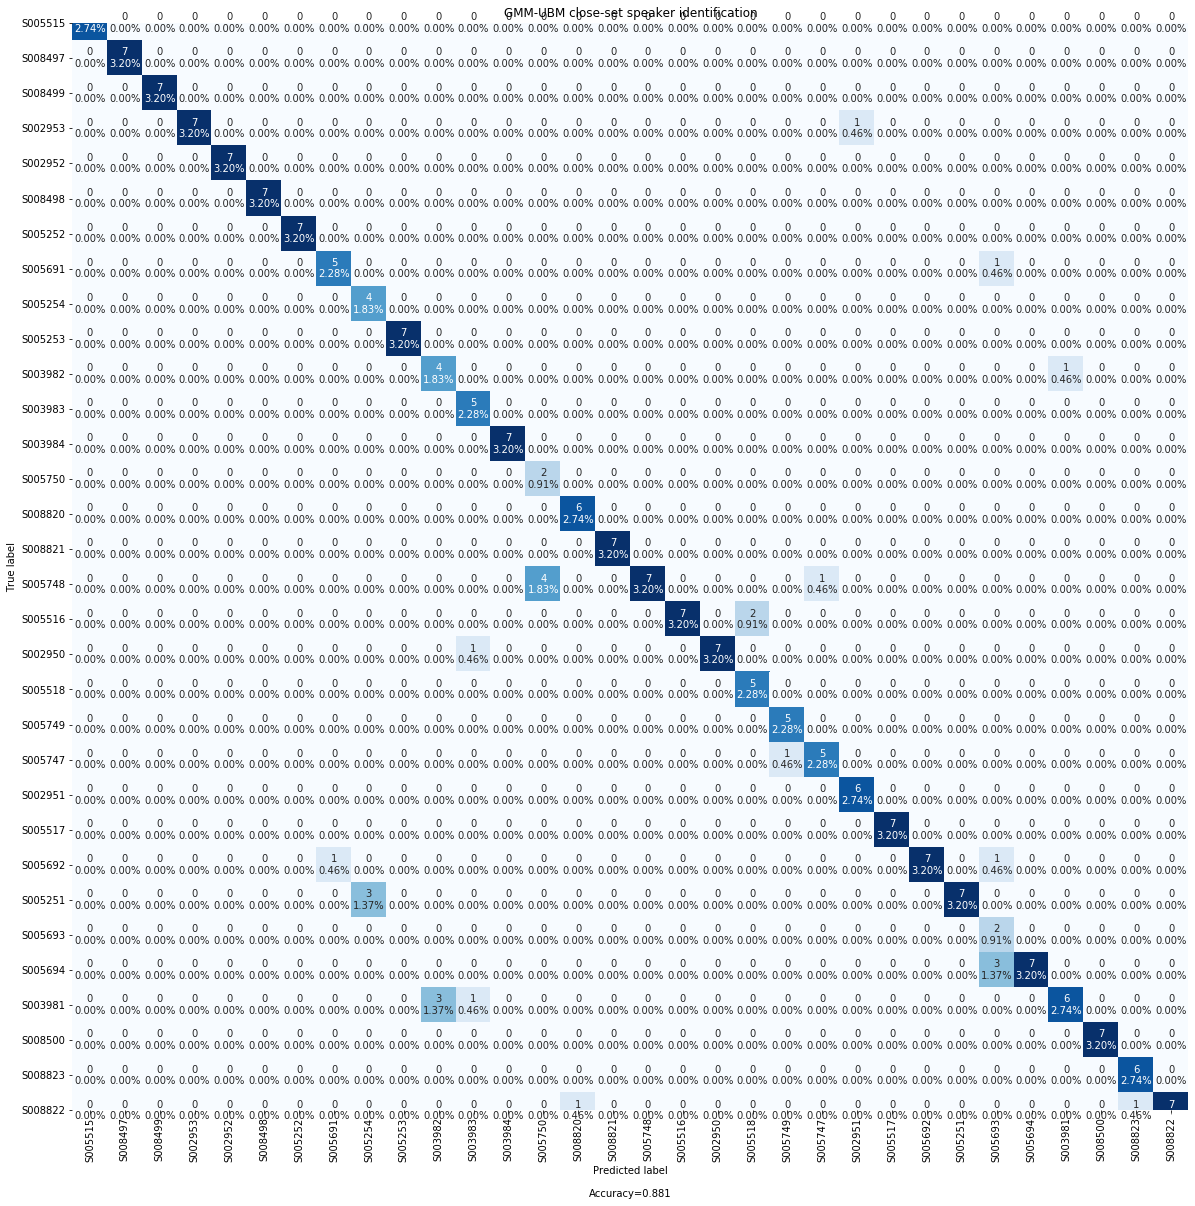

In [83]:
make_confusion_matrix(cfmatrix,figsize=(20,20), cbar=False,categories =speakers, title='GMM close-set speaker identification')

#### FA vs FR , and what is  EER

In [107]:
cfmatrix = np.zeros((len(speakers)+1,len(speakers)+1))

In [108]:
for true_lbl, datas in enumerate(speakers_test):
    for data in datas:
        log_likelihood = np.zeros(len(speakers)) 
        for j,m in enumerate(speaker_models):
            log_likelihood[j] = m.score(data)
        predict_lbl = np.argmax(log_likelihood)
        if log_likelihood[predict_lbl] < -45:
            predict_lbl = len(speakers)
        cfmatrix[predict_lbl,true_lbl]+=1

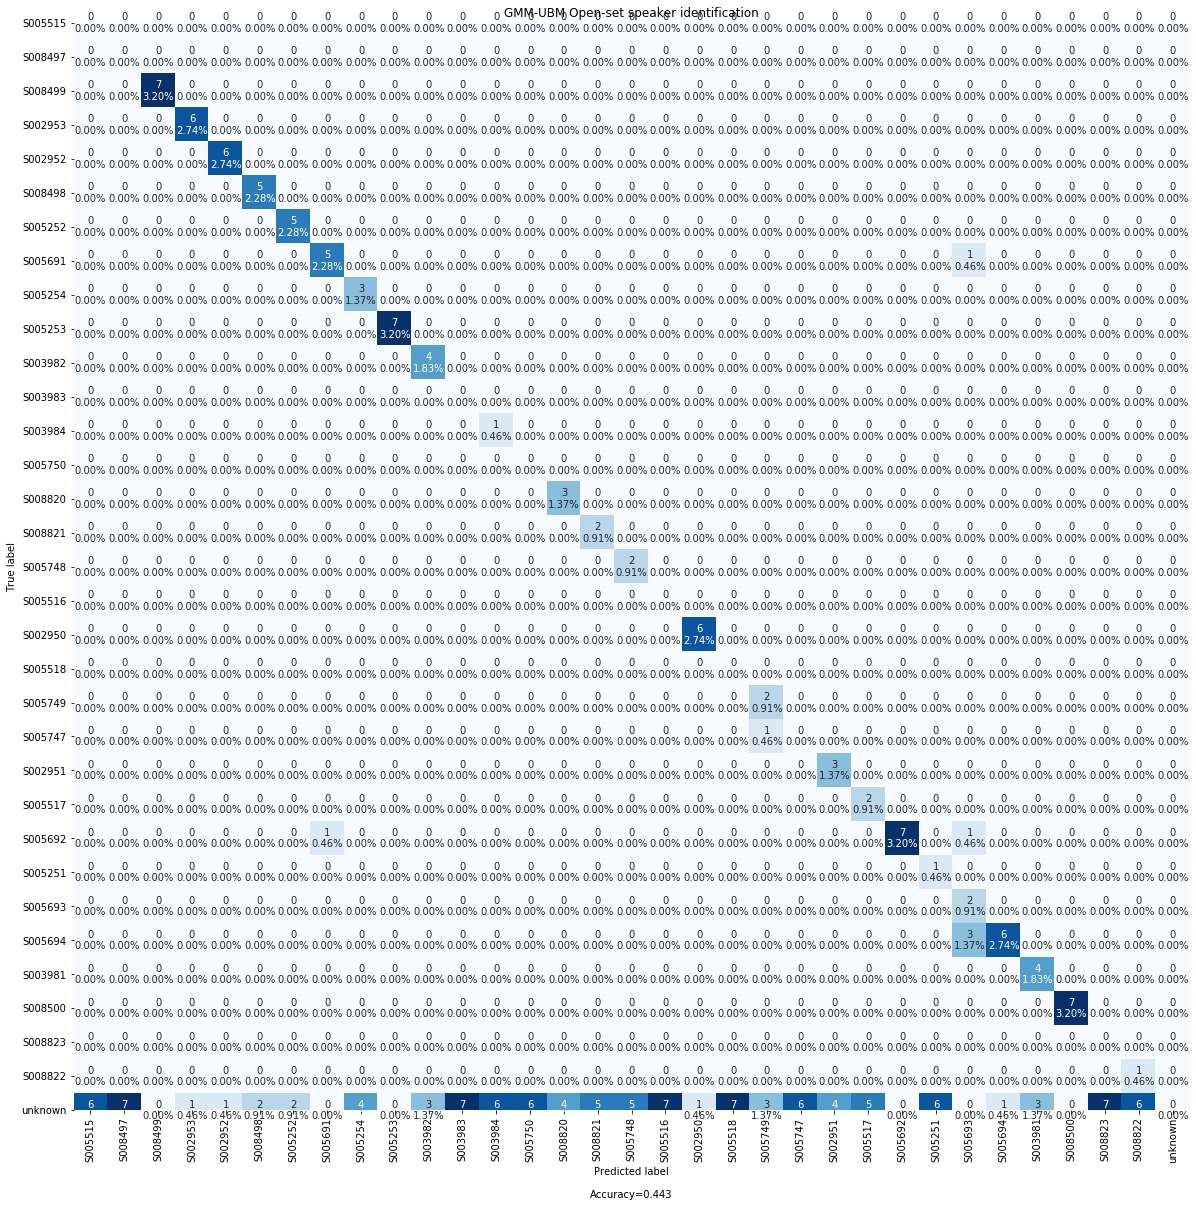

In [109]:
make_confusion_matrix(cfmatrix,figsize=(20,20), cbar=False,categories =speakers+['unknown'], title='GMM-UBM Open-set speaker identification')